## Imports

In [1]:
# Use this cell to regroup all your imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

from xgboost import XGBRegressor

from sklearn import set_config
set_config(display = 'diagram')

# Sklearn preprocessing
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel, GenericUnivariateSelect
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer, make_column_selector
import math

# 🏆 Le Wagon Kaggle Batch Challenge

**Welcome to your first Kaggle competition!**

<img src='https://wagon-public-datasets.s3.amazonaws.com/data-science-images/ML/kaggle-batch-challenge.png' width=600>

Your objective is to **submit an answer (online)** to the open competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 🏠

Fortunately, you have already come across the housing dataset earlier in the bootcamp! You will be semi-guided toward a **baseline model**, and only after creating a baseline will you be free to improve and refine it. We will approach the problem using **pipelines** (the best practice)!

A few words on Kaggle:
- Kaggle will rank your submission amongst all participants!
- Everyone is removed from the public leaderboard after 2 months
- You can make up to 10 submissions per day

🧹 Today is the perfect day to practice keeping your long notebook **tidy** 🧹
- Collapse all headings from the command palette (`Cmd + Shift + P`)
- Stay  "idempotent" (`Restart & Run All` should never crash)
- Name and delete variables carefully

## Kaggle Setup

👉 Create an account on Kaggle if you want to participate in the competition

👉 Join the [House Prices Challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 

👉 Write down your Kaggle `username` in the [results spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0); if you can't find your batch, reach out to your teacher!

**The whole batch will compete as a group against the team of TAs**

## Loading Data

In the challenge instructions, you should have already executed the steps to download everything you need from Kaggle into your current notebook folder:

- `train.csv` is your `(1460, 81)` training set containing `X` and `y`
- `test.csv` is your `(1459, 80)` testing set without the associated target `y` 😈
- `sample_submission.csv` describes the format required to submit your answer

ℹ️ You'll find a detailed description of the dataset [here](https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/07-Ensemble-Methods/kaggle_houses_data_description.txt). Refer to it throughout the challenge!

Your goal is to predict the `y_pred` missing from your test set and submit it to discover your `test_score` and ranking

❓ Load the training dataset into a DataFrame called `data`, and create your `X` and `y`. Inspect their shapes.

**Hint:** if you check the CSV file, you will notice a column called `Id`. When reading the CSV file into a DF, make sure to set `index_col="Id"` so that you don't get two ID columns 😉

In [2]:
data = pd.read_csv('./data/train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
data.shape

(1460, 81)

In [4]:
X = data.drop(columns=['SalePrice','Id'])
y = data['SalePrice']

# 🐣 1. BASELINE

## 1.1 Initial feature overview

80 features are too much to deal with one by one for a first baseline pipeline! Let's treat them solely based on their `dtype`:

❓ How many numerical features vs. categorical features do we have? 

In [5]:
numerical_features = X.select_dtypes(include=['int','float'])
numerical_features.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [6]:
numerical_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,460,0,40,0,0,0,0,0,8,2007
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,500,349,0,0,0,0,0,0,2,2010
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,252,0,60,0,0,0,0,2500,5,2010
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,240,366,0,112,0,0,0,0,4,2010


In [7]:
correlation_matrix = numerical_features.corr()
correlation_matrix

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
MSSubClass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,...,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407
LotFrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,...,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450
LotArea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,...,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261
OverallQual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,...,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347
OverallCond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,...,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950
YearBuilt,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,...,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618
YearRemodAdd,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,...,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743
MasVnrArea,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,...,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201
BsmtFinSF1,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,...,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359
BsmtFinSF2,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,...,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706


<AxesSubplot:>

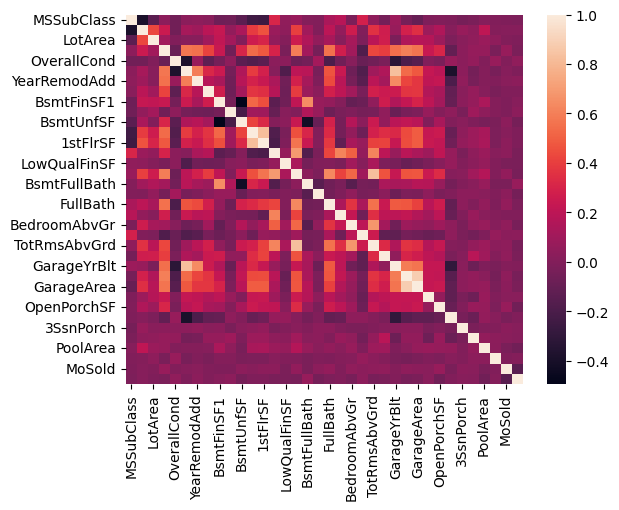

In [8]:
sns.heatmap(numerical_features.corr())

In [9]:
threshold = 0.7

high_correlation = correlation_matrix > abs(threshold) 
np.fill_diagonal(high_correlation.values, False)
redundant_features = [column for column in high_correlation.columns if any(high_correlation[column])]
redundant_features

numerical_features_uncorrelated = numerical_features.drop(columns=redundant_features)
numerical_features_uncorrelated

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Fireplaces,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,196.0,706,0,150,...,0,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,0.0,978,0,284,...,1,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2002,162.0,486,0,434,...,1,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1970,0.0,216,0,540,...,1,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,350.0,655,0,490,...,1,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,2000,0.0,0,0,953,...,1,0,40,0,0,0,0,0,8,2007
1456,20,85.0,13175,6,6,1988,119.0,790,163,589,...,2,349,0,0,0,0,0,0,2,2010
1457,70,66.0,9042,7,9,2006,0.0,275,0,877,...,2,0,60,0,0,0,0,2500,5,2010
1458,20,68.0,9717,5,6,1996,0.0,49,1029,0,...,0,366,0,112,0,0,0,0,4,2010


In [10]:
categorial_features = X.select_dtypes(include='object')
categorial_features

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


❓ Create a Series called `feat_categorical_nunique` containing the number of **unique values** for each categorical feature in our training set. How many unique categories are there in total?

In [11]:
feat_categorical_nunique = categorial_features.nunique()

In [12]:
feat_categorical_nunique.sort_values()

Street            2
Alley             2
CentralAir        2
Utilities         2
LandSlope         3
PoolQC            3
PavedDrive        3
GarageFinish      3
BsmtQual          4
ExterQual         4
MasVnrType        4
KitchenQual       4
BsmtCond          4
BsmtExposure      4
Fence             4
MiscFeature       4
LandContour       4
LotShape          4
FireplaceQu       5
Electrical        5
HeatingQC         5
GarageQual        5
GarageCond        5
MSZoning          5
LotConfig         5
BldgType          5
ExterCond         5
BsmtFinType1      6
RoofStyle         6
GarageType        6
Foundation        6
Heating           6
BsmtFinType2      6
SaleCondition     6
Functional        7
RoofMatl          8
HouseStyle        8
Condition2        8
SaleType          9
Condition1        9
Exterior1st      15
Exterior2nd      16
Neighborhood     25
dtype: int64

🤔 If we were to `OneHotEncode` all categorical features, our feature matrix `X_preproc` would become pretty big and sparse, with almost 300 (highly correlated) features for only 1400 observations. Ideally, we should aim at feeding our model with a maximum of ~50 features (📚 read this [rule of thumb](https://datascience.stackexchange.com/a/11480/98300))

We know 2 main strategies to reduce the number of categorical features post-preprocessing:
1. **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to our model; this may require statistical analysis of feature importance
2. **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot encode) categorical features into integers; this, however, creates a notion of "order" (1 > 2 > 3 > ...) that can be detrimental if not handled properly!

❓ Plot the **histogram** of the number of unique values per categorical feature. Do you see some quick wins?

<function matplotlib.pyplot.show(close=None, block=None)>

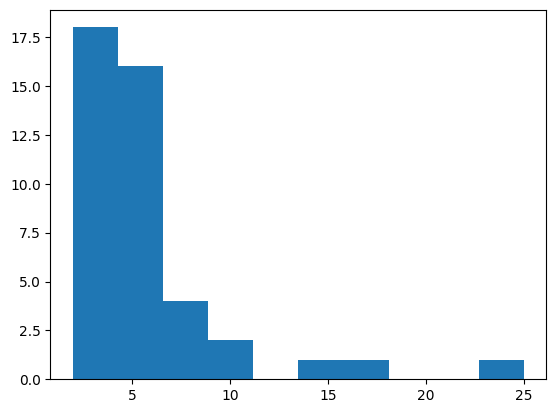

In [13]:
plt.hist(feat_categorical_nunique)
plt.show

💡 As a starting point, what about simply **removing** all features that have **7 unique values or more**, and one-hot encoding the rest? Let's keep ordinal encoding and statistical feature selection for the next iteration of our pipeline.

❓ Store the names of the features to be OHE'd in a list called `feat_categorical_small` below. How many features will be OHE'd?

In [14]:
categorical_features_filtered = categorial_features.drop(columns=['Neighborhood','Exterior1st','Exterior2nd','Condition1','SaleType','Condition2','HouseStyle','RoofMatl','Functional'])

In [15]:
feat_categorical_small = categorical_features_filtered.columns

In [16]:
feat_categorical_small

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleCondition'],
      dtype='object')

🧪 Test your code below (and clear the cell once it passed)

In [17]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'features_overview',
    n=len(feat_categorical_small)
)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/Ed/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/Ed/code/E-Brown96/05-ML/07-Ensemble-Methods/data-houses-kaggle-competition/tests
plugins: asyncio-0.19.0, typeguard-2.13.3, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 1 item

test_features_overview.py::TestFeaturesOverview::test_feat_categorical_small PASSED [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/features_overview.pickle

git commit -m 'Completed features_overview step'

git push origin master



In [18]:
categorical_features_filtered["ExterCond"].unique()

array(['TA', 'Gd', 'Fa', 'Po', 'Ex'], dtype=object)

## 1.2 Baseline Pipe

### a) Preprocessing

❓ Let's code the basic preprocessing pipeline described below. Save it under `preproc_baseline`.

For categorical features:
- Simple-Impute with the most frequent values
- One-Hot Encode features that have less than 7 unique values to start with
- Drop all other features


As for numerical features:
- Simple-Impute with strategy `mean`
- Min-Max Scale


<details>
    <summary>ℹ️ Click here for a pro tip</summary>

If you are confident, you can try Sklearn's shorter-syntax `make_pipeline` or `make_column_transformer` instead of the longer syntax of `Pipeline` or `ColumnTransformer`; also useful if you want to avoid giving names manually to every step.
</details>

In [19]:
#Pipeline time

# Numerical Preprocessor
numerical = Pipeline([
    ("simpleimputer", SimpleImputer(strategy="mean")), # imputer
    ("robustscaler",MinMaxScaler()), # scaler
])

# Categorical preprocessor
encoder = OneHotEncoder(handle_unknown='ignore')

categorical = Pipeline([
    ('simpleimputer', SimpleImputer(strategy='most_frequent')), #imputer for categorical
    ('encoder', encoder)
])

#Preprocessor

preprocessor = ColumnTransformer([
    ('numerical',numerical, numerical_features_uncorrelated.columns),
    ('categorical',categorical, feat_categorical_small)
])

preprocessor

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('robustscaler',
                                                  MinMaxScaler())]),
                                 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'Bedr...
       'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleCondition'],
      dtype='object'))])

❓ Look at the **shape** of your preprocessed DataFrame and save it to `shape_preproc_baseline`

In [20]:
preproc_baseline = preprocessor.fit_transform(X,y)

In [21]:
shape_preproc_baseline = preproc_baseline.shape
shape_preproc_baseline

(1460, 175)

🧪 Test your code below

### b) Add Estimator

❓ Add a simple Decision Tree model to your `preproc_baseline` and store it to `pipe_baseline` variable.

In [22]:
pipe_baseline = Pipeline([
    ('preprocessor',preprocessor), # Preprocessing block
    ('model', DecisionTreeRegressor()) # Add a model 
])

pipe_baseline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfB...
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleCondition'],
      dtype='object'))])),
                ('model', DecisionTreeRegressor())])

### c) Cross-Validate

❓ Read the Kaggle [contest evaluation rules](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation). Which performance metric do you need? Is it readily available in Sklearn?

Sadly, it isn't! We will need to create our custom `sklearn.metrics.scorer` object to pass to any cross-validation or Grid Search. The process is described below:


1. Create a scorer called `rmsle` using [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) that can be passed as a value for the `scoring` `kwarg` like so:  
    ```python
    cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle)
    ```
2.  Create its negative counterpart, `rmsle_neg`, which is best when _maximized_; this will come in handy later as `GridSearchCV` always tries to _maximize_ a score 😉
    ```python
    GridSearchCV(pipe_baseline, param_grid=..., cv=5, scoring=rmsle_neg)
    ```

RMSLE formula

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [23]:
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
def rmse(y_true,y_pred):
    return mean_squared_log_error(y_true,y_pred, squared=True)**(1/2)
def nrmse(y_true,y_pred):
    return -1*mean_squared_log_error(y_true,y_pred, squared=True)**(1/2)

In [24]:
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
rmsle = make_scorer(rmse)
rmsle_neg = make_scorer(nrmse)

❓5-fold cross-validate your `pipe_baseline` using this metric to get a first glance at your baseline performance.    

Store your mean score as `score_baseline`

In [25]:
pipe_baseline.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfB...
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleCondition'],
      dtype='object'))])),
                ('model', DecisionTreeRegressor())])

In [26]:
score_baseline = cross_validate(pipe_baseline, X, y, cv=5, scoring=rmsle)['test_score'].mean()
score_baseline

0.2202413160318625

### d) Predict Baseline

❓ Predict `y_pred_baseline` from the Kaggle `test.csv` dataset you stored in the `data` folder.

In [27]:
test_data = pd.read_csv('./data/test.csv')

In [28]:
test_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [29]:
pipe_baseline.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfB...
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleCondition'],
      dtype='object'))])),
                ('model', DecisionTreeRegressor())])

In [30]:
y_pred_baseline = pipe_baseline.predict(test_data)[0].mean()
y_pred_baseline

144000.0

In [31]:
 y_pred = pipe_baseline.predict(test_data)

❓ Finally, store your ready-to-submit CSV as `submission_baseline.csv` in the `data` folder. **Carefully read** and understand Kaggle's required format and test it below (you don't need to submit this baseline to Kaggle for now).

In [32]:
temp_predicted_data = pd.DataFrame(pipe_baseline.predict(test_data))
temp_predicted_data['Id'] = test_data['Id'].astype(int)
temp_predicted_data['SalePrice'] = temp_predicted_data[0]
temp_predicted_data.drop(columns=0, inplace=True)
predicted_data = temp_predicted_data.set_index('Id').astype(int)
predicted_data['SalePrice'] = predicted_data['SalePrice'].astype(float)
predicted_data

,SalePrice
Id,
1461,144000.0
1462,215000.0
1463,175000.0
1464,171500.0
1465,180000.0
...,...
2915,80000.0
2916,113000.0
2917,121500.0


In [33]:
# Specify the path and filename for the new CSV file
csv_file_path = '/Users/Ed/code/E-Brown96/05-ML/07-Ensemble-Methods/data-houses-kaggle-competition/data/submission_baseline.csv'

# Export the DataFrame to a new CSV file
predicted_data.to_csv(csv_file_path, index=True)

🧪 Test your code

In [34]:
from nbresult import ChallengeResult

tmp = pd.read_csv("data/submission_baseline.csv")

result = ChallengeResult(
    'submission_baseline',
    score_baseline = score_baseline,
    submission_shape = tmp.shape,
    submission_columns = list(tmp.columns),
    submission_dtypes = str(list(tmp.dtypes)),
)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/Ed/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/Ed/code/E-Brown96/05-ML/07-Ensemble-Methods/data-houses-kaggle-competition/tests
plugins: asyncio-0.19.0, typeguard-2.13.3, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 4 items

test_submission_baseline.py::TestSubmissionBaseline::test_score_baseline PASSED [ 25%]
test_submission_baseline.py::TestSubmissionBaseline::test_submission_columns PASSED [ 50%]
test_submission_baseline.py::TestSubmissionBaseline::test_submission_dtypes PASSED [ 75%]
test_submission_baseline.py::TestSubmissionBaseline::test_submission_shape PASSED [100%]

============================== 4 passed in 0.05s ===============================


💯 You can commit your code:

git add tests/submission_baseline.pickle

git commit -m 'Completed submission_baseline step'

git push orig

# 🏋️‍♀️ 2. ITERATIONS 

🎉 🎉 Congratulation on having fully pipelined a baseline model! You will see now how much easier it is to iterate and improve performance 🚀

Now, your goal is to improve your prediction and submit it to Kaggle **at least 30 minutes before the Recap ⏳**

We have some suggestions for improvements below: **pick your battles** and **incrementally** improve your pipeline as you see fit!

**Estimators**

- Tree-based ensembles (a must-try today); probably the best suited for problems with many categorical features
- Stacking!
- XGBoost!

**Preprocessing** (once your first ensemble model works)

- **Ordinal Encoding** of categorical features with a hidden notion of order in their values (e.g. "bad", "average", good")
- **Statistical Feature Selection** to remove useless features (avoids overfitting and reduces training time)
- Predict `log(SalePrice)` instead?
- 🤷

## 2.1 Preprocessing Iteration ♲ 
**⚠️ Come back here only after you have iterated on your estimators in section 2.2 ⚠️**

⏩ Collapse me if I'm not in use!

### a) Ordinal Encoding (~1h)

❓ Look at the following feature. Couldn't it be encoded numerically in a wise manner?
```
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
```

💡 Luckily, the `OrdinalEncoder` and its argument `categories`  allows us to do just that! Check it out below and make sure to understand how this works 👇

In [35]:
# Define specific order for features
# Note: if you change this order, it will change the output for .transform()
feature_A_sorted_values = ['bad', 'average', 'good'] 
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ["average", "clean"],
        ['good', 'new'],
        ['bad', 'oops never seen this label before']
])

array([[ 0.,  0.],
       [ 1.,  1.],
       [ 2.,  2.],
       [ 0., -1.]])

❓ **Your turn**: split your categorical preprocessor into

- `preproc_ordinal` to ordinally encode **some features** (of your choice)
- `preproc_nominal` to one-hot encode the other ones


<details>
    <summary>Hints</summary>

- You won't be able to avoid hard-coding names and ordered values of features! Be tidy!
- It's a good practice to sort your features alphabetically to avoid bad surprises
</details>

In [36]:
categorical_features_filtered["ExterCond"].unique()

array(['TA', 'Gd', 'Fa', 'Po', 'Ex'], dtype=object)

In [37]:
Sale_cond_sorted_values = ['Abnorml', 'AdjLand','Family', 'Alloca','Normal','Partial']
Exter_cond_sorted_values = ['Po', 'TA', 'Fa','Gd', 'Ex']
Kitchen_qual_sorted_values = ['TA', 'Fa', 'Gd', 'Ex']

encoder = OrdinalEncoder(
    categories=[
        Sale_cond_sorted_values,
        Exter_cond_sorted_values,
        Kitchen_qual_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

In [38]:
feat_categorical_ordinal = categorical_features_filtered[['SaleCondition','ExterCond','KitchenQual']].columns
feat_categorical_ordinal

Index(['SaleCondition', 'ExterCond', 'KitchenQual'], dtype='object')

In [39]:
feat_categorical_one_hot = categorical_features_filtered.drop(columns=['SaleCondition','ExterCond','KitchenQual']).columns
feat_categorical_one_hot

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'MasVnrType',
       'ExterQual', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature'],
      dtype='object')

In [40]:
#Pipeline time

# Numerical Preprocessor
numerical = Pipeline([
    ("simpleimputer", SimpleImputer(strategy="mean")), # imputer
    ("robustscaler",MinMaxScaler()), # scaler
])

# Categorical preprocessor one hot encoded
encoder_one_hot = OneHotEncoder(handle_unknown='ignore')

categorical_one_hot = Pipeline([
    ('simpleimputer', SimpleImputer(strategy='most_frequent')), #imputer for categorical
    ('encoder', encoder_one_hot)
])

# Categorical preprocessor ordinal encoded
encoder_ordinal = OrdinalEncoder(
    categories=[
        Sale_cond_sorted_values,
        Exter_cond_sorted_values,
        Kitchen_qual_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

categorical_ordinal = Pipeline([
    ('simpleimputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', encoder_ordinal)
])

#Preprocessor

preprocessor = ColumnTransformer([
    ('numerical',numerical, numerical_features_uncorrelated.columns),
    ('categorical_one_hot',categorical_one_hot, feat_categorical_one_hot),
    ('categorical_ordinal', categorical_ordinal, feat_categorical_ordinal)
])

preprocessor

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('robustscaler',
                                                  MinMaxScaler())]),
                                 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'Bedr...
                                ('categorical_ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(categories=[['Abnorml',
                                                                              'AdjLand',
                                                                              'Family',
                                                                              'Alloca',
                                                                              'Normal',
                                                                              'Partial'],
                                                                             ['Po',
                                                                              'TA',
                                                                              'Fa',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['TA',
                                                                              'Fa',
                                                                              'Gd',
                                                                              'Ex']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 Index(['SaleCondition', 'ExterCond', 'KitchenQual'], dtype='object'))])

In [41]:
pipe_baseline_ordinal = Pipeline([
    ('preprocessor',preprocessor), # Preprocessing block
    ('model', DecisionTreeRegressor()) # Add a model 
])

pipe_baseline_ordinal

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfB...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(categories=[['Abnorml',
                                                                                               'AdjLand',
                                                                                               'Family',
                                                                                               'Alloca',
                                                                                               'Normal',
                                                                                               'Partial'],
                                                                                              ['Po',
                                                                                               'TA',
                                                                                               'Fa',
                                                                                               'Gd',
                                                                                               'Ex'],
                                                                                              ['TA',
                                                                                               'Fa',
                                                                                               'Gd',
                                                                                               'Ex']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  Index(['SaleCondition', 'ExterCond', 'KitchenQual'], dtype='object'))])),
                ('model', DecisionTreeRegressor())])

In [42]:
#Testing the new pipeline model
pipe_baseline_ordinal.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfB...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(categories=[['Abnorml',
                                                                                               'AdjLand',
                                                                                               'Family',
                                                                                               'Alloca',
                                                                                               'Normal',
                                                                                               'Partial'],
                                                                                              ['Po',
                                                                                               'TA',
                                                                                               'Fa',
                                                                                               'Gd',
                                                                                               'Ex'],
                                                                                              ['TA',
                                                                                               'Fa',
                                                                                               'Gd',
                                                                                               'Ex']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  Index(['SaleCondition', 'ExterCond', 'KitchenQual'], dtype='object'))])),
                ('model', DecisionTreeRegressor())])

In [43]:
score_baseline = cross_validate(pipe_baseline_ordinal, X, y, cv=5, scoring=rmsle)['test_score'].mean()
score_baseline

0.22861106293486227

In [44]:
y_pred_baseline = pipe_baseline_ordinal.predict(test_data)[0].mean()
y_pred_baseline

142600.0

In [45]:
 y_pred = pipe_baseline_ordinal.predict(test_data)

In [46]:
temp_predicted_data = pd.DataFrame(pipe_baseline_ordinal.predict(test_data))
temp_predicted_data['Id'] = test_data['Id'].astype(int)
temp_predicted_data['SalePrice'] = temp_predicted_data[0]
temp_predicted_data.drop(columns=0, inplace=True)
predicted_data = temp_predicted_data.set_index('Id').astype(int)
predicted_data['SalePrice'] = predicted_data['SalePrice'].astype(float)
predicted_data

,SalePrice
Id,
1461,142600.0
1462,155000.0
1463,180000.0
1464,179900.0
1465,180000.0
...,...
2915,97000.0
2916,97000.0
2917,143000.0


### b) Statistical Feature Selection (~30min)

Our goal is to remove the least interesting features to limit overfitting and shorten training time.  

🔥 We will make use of Sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) transformers directly in your pipeline!

❗️ We recommend you try **only Option 1 today**, to start with. Options 2 and 3 will be corrected in the Recap!

#### Option 1 (Recommended) - <font color=green>Univariate</font> Feature Selection
*based on their mutual information with target `y`*

- Feel free to add a `SelectPercentile` filter at the end of your `preproc` pipeline.
- This will filter out features that, taken individually, least explain your target!
- The statistical test we recommend passing to SelectPercentile is the `mutual_info_regression`

<details>
    <summary markdown='span'>🤔 What is mutual information? Click here!</summary>

- [Mutual Information](https://en.wikipedia.org/wiki/Mutual_information) is a **statistical** distance between two probability distributions
- Correlation is a **linear** distance between two random variables
- Mutual Information is more general and measures the reduction of uncertainty in Y after observing X.
- On the other hand, if you already know you are working with variables that are smooth (like continuous numerical variables), sometimes correlation may tell you more about them, for instance if their relationship is monotonic.

See [this animation](https://twitter.com/ari_seff/status/1409296508634152964)
</details>

In [47]:
#Pipeline time with added feature selection

# Feature selection transformer based on mutual information
feature_selector_mi = SelectPercentile(mutual_info_regression, percentile=50)  # Adjust percentile as needed

# Updated numerical preprocessor with feature selection
numerical = Pipeline([
    ("simpleimputer", SimpleImputer(strategy="mean")),  # imputer
    ("robustscaler", MinMaxScaler()),  # scaler
    ("feature_selection", feature_selector_mi)  # feature selection
])

# Updated categorical preprocessor with feature selection
categorical_one_hot_fs = Pipeline([
    ('simpleimputer', SimpleImputer(strategy='most_frequent')),  # imputer for categorical
    ('encoder', encoder_one_hot),
    ('feature_selection', feature_selector_mi)  # feature selection
])

categorical_ordinal_fs = Pipeline([
    ('simpleimputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', encoder_ordinal),
    ('feature_selection', feature_selector_mi)  # feature selection
])

# Updated preprocessor
preprocessor_percentile = ColumnTransformer([
    ('numerical', numerical, numerical_features_uncorrelated.columns),
    ('categorical_one_hot', categorical_one_hot_fs, feat_categorical_one_hot),
    ('categorical_ordinal', categorical_ordinal_fs, feat_categorical_ordinal)
])

preprocessor_percentile

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('robustscaler',
                                                  MinMaxScaler()),
                                                 ('feature_selection',
                                                  SelectPercentile(percentile=50,
                                                                   score_func=<function mutual_info_regression at 0x15114dcf0>))]),
                                 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF...
                                                  OrdinalEncoder(categories=[['Abnorml',
                                                                              'AdjLand',
                                                                              'Family',
                                                                              'Alloca',
                                                                              'Normal',
                                                                              'Partial'],
                                                                             ['Po',
                                                                              'TA',
                                                                              'Fa',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['TA',
                                                                              'Fa',
                                                                              'Gd',
                                                                              'Ex']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('feature_selection',
                                                  SelectPercentile(percentile=50,
                                                                   score_func=<function mutual_info_regression at 0x15114dcf0>))]),
                                 Index(['SaleCondition', 'ExterCond', 'KitchenQual'], dtype='object'))])

In [48]:
pipe_baseline_percentile = Pipeline([
    ('preprocessor',preprocessor_percentile), # Preprocessing block
    ('model', DecisionTreeRegressor()) # Add a model 
])

pipe_baseline_percentile.fit(X,y)

score_baseline = cross_validate(pipe_baseline_percentile, X, y, cv=5, scoring=rmsle)['test_score'].mean()

y_pred_baseline = pipe_baseline_percentile.predict(test_data)[0].mean()

y_pred = pipe_baseline_percentile.predict(test_data)

temp_predicted_data = pd.DataFrame(pipe_baseline_percentile.predict(test_data))

temp_predicted_data['Id'] = test_data['Id'].astype(int)

temp_predicted_data['SalePrice'] = temp_predicted_data[0]

temp_predicted_data.drop(columns=0, inplace=True)

predicted_data = temp_predicted_data.set_index('Id').astype(int)

predicted_data['SalePrice'] = predicted_data['SalePrice'].astype(float)

predicted_data

,SalePrice
Id,
1461,123000.0
1462,215000.0
1463,170000.0
1464,179900.0
1465,180000.0
...,...
2915,75000.0
2916,91000.0
2917,121500.0


#### Option 2 - <font color=green>Multivariate</font> Feature Selection
*based on their combined relationship with target `y`*

🤔 We want to remove features that do not help predict our target even when combined with all the others.

1️⃣ To do so, remember that we can use the [`permutation_importance`](https://scikit-learn.org/stable/modules/permutation_importance.html) metric in combination with an estimator! It trains one pipe per feature to estimate which feature makes our performance score *decrease* the most when shuffling it randomly. These would be our most important features, which we don't want to remove.

The best thing is that `scikit-learn` allows you to integrate this methodology directly into your `preproc` pipeline thanks to the [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) transformer; this will recursively remove the least important features according to the `cross_val_score`.

When you have many features, however, this process can take extremely long to train.

2️⃣ Alternatively, a faster way would be to make use of models that already output some measure of `feature_importance` when being fitted. For instance, trees with a Gini-based `feature_importance_`, or Lasso regressions with an L1 `coef_`. `scikit-learn` already has the [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) transformer to do just that.

In [49]:
#Pipeline time with added feature selection

# Feature selection transformer based on mutual information
feature_selector_tree = SelectFromModel(DecisionTreeRegressor())

# Updated numerical preprocessor with feature selection
numerical = Pipeline([
    ("simpleimputer", SimpleImputer(strategy="mean")),  # imputer
    ("robustscaler", MinMaxScaler()),  # scaler
    ("feature_selection", feature_selector_tree)  # feature selection
])

# Updated categorical preprocessor with feature selection
categorical_one_hot_fs = Pipeline([
    ('simpleimputer', SimpleImputer(strategy='most_frequent')),  # imputer for categorical
    ('encoder', encoder_one_hot),
    ('feature_selection', feature_selector_tree)  # feature selection
])

categorical_ordinal_fs = Pipeline([
    ('simpleimputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', encoder_ordinal),
    ('feature_selection', feature_selector_tree)  # feature selection
])

# Updated preprocessor
preprocessor_selector_tree = ColumnTransformer([
    ('numerical', numerical, numerical_features_uncorrelated.columns),
    ('categorical_one_hot', categorical_one_hot_fs, feat_categorical_one_hot),
    ('categorical_ordinal', categorical_ordinal_fs, feat_categorical_ordinal)
])

preprocessor_selector_tree

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('robustscaler',
                                                  MinMaxScaler()),
                                                 ('feature_selection',
                                                  SelectFromModel(estimator=DecisionTreeRegressor()))]),
                                 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       '2ndFlrSF'...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(categories=[['Abnorml',
                                                                              'AdjLand',
                                                                              'Family',
                                                                              'Alloca',
                                                                              'Normal',
                                                                              'Partial'],
                                                                             ['Po',
                                                                              'TA',
                                                                              'Fa',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['TA',
                                                                              'Fa',
                                                                              'Gd',
                                                                              'Ex']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('feature_selection',
                                                  SelectFromModel(estimator=DecisionTreeRegressor()))]),
                                 Index(['SaleCondition', 'ExterCond', 'KitchenQual'], dtype='object'))])

In [50]:
pipe_baseline_selector = Pipeline([
    ('preprocessor',preprocessor_selector_tree), # Preprocessing block
    ('model', DecisionTreeRegressor()) # Add a model 
])

pipe_baseline_selector.fit(X,y)

score_baseline = cross_validate(pipe_baseline_selector, X, y, cv=5, scoring=rmsle)['test_score'].mean()

y_pred_baseline = pipe_baseline_selector.predict(test_data)[0].mean()

y_pred = pipe_baseline_selector.predict(test_data)

temp_predicted_data = pd.DataFrame(pipe_baseline_selector.predict(test_data))

temp_predicted_data['Id'] = test_data['Id'].astype(int)

temp_predicted_data['SalePrice'] = temp_predicted_data[0]

temp_predicted_data.drop(columns=0, inplace=True)

predicted_data = temp_predicted_data.set_index('Id').astype(int)

predicted_data['SalePrice'] = predicted_data['SalePrice'].astype(float)

predicted_data

,SalePrice
Id,
1461,117000.0
1462,181900.0
1463,143000.0
1464,156000.0
1465,170000.0
...,...
2915,75000.0
2916,120000.0
2917,217500.0


#### Option 3 - <font color=green>Unsupervised</font> Selection?
*filter based only on the properties of `X`*

❓ A quick win is to remove features with the lowest variance. Think about it: a feature that only has one value is useless (and has a variance of 0).

Feel free to add a [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) to the end of your pipeline!

In [51]:
#Pipeline time with added feature selection and variance threshold

# Feature selection transformer based on mutual information
feature_selector_tree = SelectFromModel(DecisionTreeRegressor())
variance_selector = VarianceThreshold(threshold=0.01)

# Updated numerical preprocessor with feature selection
numerical = Pipeline([
    ("simpleimputer", SimpleImputer(strategy="mean")),  # imputer
    ("robustscaler", MinMaxScaler()),  # scaler
    ("feature_selection", feature_selector_tree),  # feature selection
    ("variance_selector", variance_selector)
])

# Updated categorical preprocessor with feature selection
categorical_one_hot_fs = Pipeline([
    ('simpleimputer', SimpleImputer(strategy='most_frequent')),  # imputer for categorical
    ('encoder', encoder_one_hot),
    ('feature_selection', feature_selector_tree),  # feature selection
    ("variance_selector", variance_selector)
])

categorical_ordinal_fs = Pipeline([
    ('simpleimputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', encoder_ordinal),
    ('feature_selection', feature_selector_tree),  # feature selection
    ("variance_selector", variance_selector)
])

# Updated preprocessor
preprocessor_selector_final = ColumnTransformer([
    ('numerical', numerical, numerical_features_uncorrelated.columns),
    ('categorical_one_hot', categorical_one_hot_fs, feat_categorical_one_hot),
    ('categorical_ordinal', categorical_ordinal_fs, feat_categorical_ordinal)
])

preprocessor_selector_final

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('robustscaler',
                                                  MinMaxScaler()),
                                                 ('feature_selection',
                                                  SelectFromModel(estimator=DecisionTreeRegressor())),
                                                 ('variance_selector',
                                                  VarianceThreshold(threshold=0.01))]),
                                 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearRemodAdd', 'MasV...
                                                                              'AdjLand',
                                                                              'Family',
                                                                              'Alloca',
                                                                              'Normal',
                                                                              'Partial'],
                                                                             ['Po',
                                                                              'TA',
                                                                              'Fa',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['TA',
                                                                              'Fa',
                                                                              'Gd',
                                                                              'Ex']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('feature_selection',
                                                  SelectFromModel(estimator=DecisionTreeRegressor())),
                                                 ('variance_selector',
                                                  VarianceThreshold(threshold=0.01))]),
                                 Index(['SaleCondition', 'ExterCond', 'KitchenQual'], dtype='object'))])

In [52]:
pipe_baseline_final = Pipeline([
    ('preprocessor',preprocessor_selector_final), # Preprocessing block
    ('model', DecisionTreeRegressor()) # Add a model 
])

pipe_baseline_final.fit(X,y)

score_baseline = cross_validate(pipe_baseline_final, X, y, cv=5, scoring=rmsle)['test_score'].mean()

y_pred_baseline = pipe_baseline_final.predict(test_data)[0].mean()

y_pred = pipe_baseline_final.predict(test_data)

temp_predicted_data = pd.DataFrame(pipe_baseline_final.predict(test_data))

temp_predicted_data['Id'] = test_data['Id'].astype(int)

temp_predicted_data['SalePrice'] = temp_predicted_data[0]

temp_predicted_data.drop(columns=0, inplace=True)

predicted_data = temp_predicted_data.set_index('Id').astype(int)

predicted_data['SalePrice'] = predicted_data['SalePrice'].astype(float)

predicted_data

,SalePrice
Id,
1461,91300.0
1462,185750.0
1463,169000.0
1464,181900.0
1465,170000.0
...,...
2915,82750.0
2916,128000.0
2917,144000.0


❓ Additionally, we can check for correlation between our **numerical features** only

- Use [Pearson's correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) combined with a heatmap to visually check whether any **numerical** features almost entirely correlate with others
- Use `VIF` from `statsmodels` to check for features that have the highest multicollinearity

<AxesSubplot:>

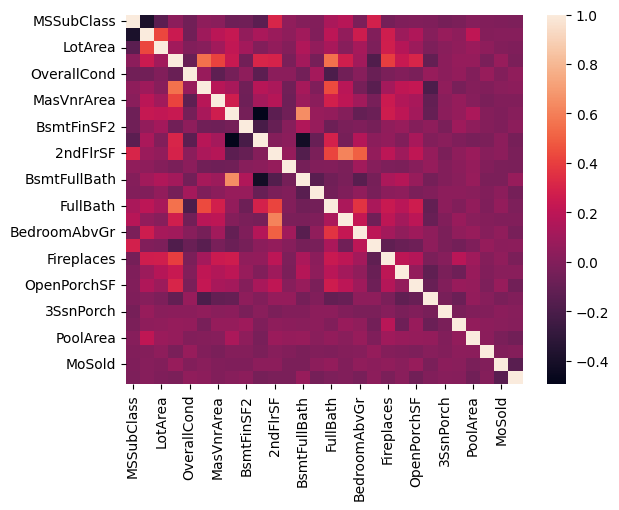

In [53]:
scaler = MinMaxScaler()
scaled_num = pd.DataFrame(scaler.fit_transform(numerical_features_uncorrelated), columns=numerical_features_uncorrelated.columns)
correlated_num = scaled_num.corr(method='pearson')
sns.heatmap(correlated_num)

❓ For **ordinal features**, we can use [Spearman's rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) instead to check whether some **ordinally encoded** features are almost entirely "ordered" similarly to others. Feel free to plot a heatmap again.

<AxesSubplot:>

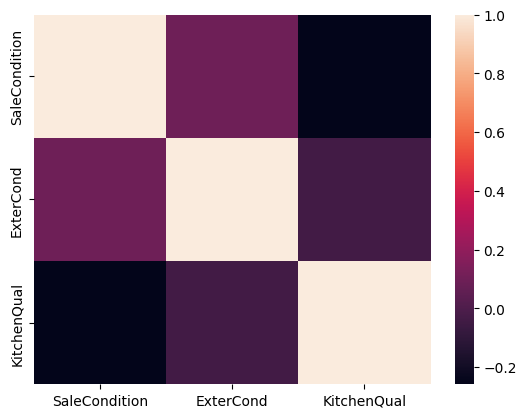

In [54]:
encoder = OrdinalEncoder()
encoded = pd.DataFrame(encoder.fit_transform(categorical_features_filtered[['SaleCondition','ExterCond','KitchenQual']]), columns=feat_categorical_ordinal)
correlated_encoded = encoded.corr(method='spearman')
sns.heatmap(correlated_encoded)

❓ Now, feel free to create a "filter" in your pipeline that removes any feature you want beyond a given (Spearman + Pearson) correlation threshold; you'll need a custom transformer class.

In [55]:
# As show above our ordinally encoded features aren't correlated but some of our numerical features are so these will be removed

#Pipeline time with added feature selection and variance threshold

#Define a function to remove numerical correlated features
def remove_corr(X):
    scaler = MinMaxScaler()
    scaled_num = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    correlated_num = scaled_num.corr(method='pearson')
    threshold = 0.6
    columns_to_keep = []
    for column in correlated_num.columns:
        for index, value in correlated_num[column].items():
            if value >= threshold and index != column:
                continue
            else:
                columns_to_keep.append(column)
                break  # Break to the next column once one condition is satisfied
    return columns_to_keep

# Feature selection transformer based on mutual information
feature_selector_tree = SelectFromModel(DecisionTreeRegressor())
variance_selector = VarianceThreshold(threshold=0.01)

# Updated numerical preprocessor with feature selection
numerical = Pipeline([
    ("simpleimputer", SimpleImputer(strategy="mean")),  # imputer
    ("robustscaler", MinMaxScaler()),  # scaler
    ("feature_selection", feature_selector_tree),  # feature selection
    ("variance_selector", variance_selector),
    ("remove_correlated", FunctionTransformer(remove_corr))
])

# Updated categorical preprocessor with feature selection
categorical_one_hot_fs = Pipeline([
    ('simpleimputer', SimpleImputer(strategy='most_frequent')),  # imputer for categorical
    ('encoder', encoder_one_hot),
    ('feature_selection', feature_selector_tree),  # feature selection
    ("variance_selector", variance_selector)
])

categorical_ordinal_fs = Pipeline([
    ('simpleimputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', encoder_ordinal),
    ('feature_selection', feature_selector_tree),  # feature selection
    ("variance_selector", variance_selector)
])

# Updated preprocessor
preprocessor_selector_corr = ColumnTransformer([
    ('numerical', numerical, numerical_features_uncorrelated.columns),
    ('categorical_one_hot', categorical_one_hot_fs, feat_categorical_one_hot),
    ('categorical_ordinal', categorical_ordinal_fs, feat_categorical_ordinal)
])

preprocessor_selector_corr

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('robustscaler',
                                                  MinMaxScaler()),
                                                 ('feature_selection',
                                                  SelectFromModel(estimator=DecisionTreeRegressor())),
                                                 ('variance_selector',
                                                  VarianceThreshold(threshold=0.01)),
                                                 ('remove_correlated',
                                                  FunctionTransformer(func=<function remove_corr at 0x156a705e0>))]),
                                 Index(['M...
                                                                              'AdjLand',
                                                                              'Family',
                                                                              'Alloca',
                                                                              'Normal',
                                                                              'Partial'],
                                                                             ['Po',
                                                                              'TA',
                                                                              'Fa',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['TA',
                                                                              'Fa',
                                                                              'Gd',
                                                                              'Ex']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('feature_selection',
                                                  SelectFromModel(estimator=DecisionTreeRegressor())),
                                                 ('variance_selector',
                                                  VarianceThreshold(threshold=0.01))]),
                                 Index(['SaleCondition', 'ExterCond', 'KitchenQual'], dtype='object'))])

### c) Treat Cyclical Features

❓ We have some time-based features, why not **transform them** into cyclical features?

In [56]:
numerical_features_uncorrelated['MoSold']

0        2
1        5
2        9
3        2
4       12
        ..
1455     8
1456     2
1457     5
1458     4
1459     6
Name: MoSold, Length: 1460, dtype: int64

### d) Target Engineering (~15min)

❓ We are asked to minimize the RMS**L**E. Why don't we transform our target to directly predict its `log`?
- Check out the histogram of the target `y`
- Normally distributed variables should be easier to predict with linear or parametric models
- Create `y_log` and your new performance metrics
- Don't forget to take the exponent of your predictions at the end!

(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <BarContainer object of 10 artists>)

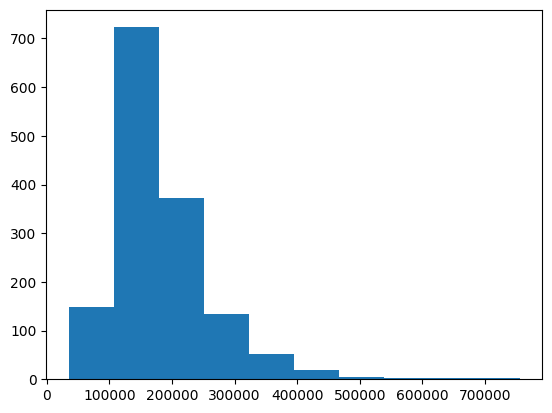

In [57]:
plt.hist(y)

In [58]:
y_log = y.apply(np.log)
y_log

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

In [59]:
#New custom metric for the y_log
def rmse(y_true,y_pred):
    return mean_squared_error(y_true,y_pred, squared=True)**(1/2)

In [60]:
#To convert back use
y_converted = y_log.apply(np.exp)
y_converted

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
1455    175000.0
1456    210000.0
1457    266500.0
1458    142125.0
1459    147500.0
Name: SalePrice, Length: 1460, dtype: float64

### 2.2 Model Iteration ♻

#### a) Final Version of the Preproc Pipeline
❓We advise you to start with a fresh definition below so you can quickly update it as needed and then try many model types to find the best one possible

In [61]:
# The final pipeline
# As show above our ordinally encoded features aren't correlated but some of our numerical features are so these will be removed

#Pipeline time with added feature selection and variance threshold

#Define a function to remove numerical correlated features
def remove_corr(X):
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])

    scaler = MinMaxScaler()
    scaled_num = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    correlated_num = scaled_num.corr(method='pearson')
    threshold = 0.6
    columns_to_keep = []
    for column in correlated_num.columns:
        for index, value in correlated_num[column].items():
            if value >= threshold and index != column:
                continue
            else:
                columns_to_keep.append(column)
                break  # Break to the next column once one condition is satisfied

    # Return the DataFrame with correlated features removed
    return X[columns_to_keep]

def cyclical_Mo(X):
    X_df = pd.DataFrame(X)
    X_df[28] = np.sin(2 * np.pi * X_df.iloc[:, -2] / 12.0)
    X_df[29] = np.cos(2 * np.pi * X_df.iloc[:, -2] / 12.0)
    X_df.drop(columns=[26], inplace=True)
    return X_df

# Feature selection transformer based on mutual information
feature_selector_tree = SelectFromModel(DecisionTreeRegressor())
variance_selector = VarianceThreshold(threshold=0.01)

# Updated numerical preprocessor with feature selection
numerical = Pipeline([
    ("simpleimputer", SimpleImputer(strategy="mean")),  # imputer
    ("add_cyclical", FunctionTransformer(cyclical_Mo)),
    ("robustscaler", MinMaxScaler()),  # scaler
    ("feature_selection", feature_selector_tree),  # feature selection
    ("variance_selector", variance_selector),
    ("remove_correlated", FunctionTransformer(remove_corr))
])

# Updated categorical preprocessor with feature selection
categorical_one_hot_fs = Pipeline([
    ('simpleimputer', SimpleImputer(strategy='most_frequent')),  # imputer for categorical
    ('encoder', encoder_one_hot),
    ('feature_selection', feature_selector_tree),  # feature selection
    ("variance_selector", variance_selector)
])

categorical_ordinal_fs = Pipeline([
    ('simpleimputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', encoder_ordinal),
    ('feature_selection', feature_selector_tree),  # feature selection
    ("variance_selector", variance_selector)
])

# Updated preprocessor
preprocessor_final = ColumnTransformer([
    ('numerical', numerical, numerical_features_uncorrelated.columns),
    ('categorical_one_hot', categorical_one_hot_fs, feat_categorical_one_hot),
    ('categorical_ordinal', categorical_ordinal_fs, feat_categorical_ordinal)
])

preprocessor_final

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('add_cyclical',
                                                  FunctionTransformer(func=<function cyclical_Mo at 0x156aa29e0>)),
                                                 ('robustscaler',
                                                  MinMaxScaler()),
                                                 ('feature_selection',
                                                  SelectFromModel(estimator=DecisionTreeRegressor())),
                                                 ('variance_selector',
                                                  VarianceThreshold(threshold=0.01)),
                                                 ('remove_correla...
                                                                              'AdjLand',
                                                                              'Family',
                                                                              'Alloca',
                                                                              'Normal',
                                                                              'Partial'],
                                                                             ['Po',
                                                                              'TA',
                                                                              'Fa',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['TA',
                                                                              'Fa',
                                                                              'Gd',
                                                                              'Ex']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('feature_selection',
                                                  SelectFromModel(estimator=DecisionTreeRegressor())),
                                                 ('variance_selector',
                                                  VarianceThreshold(threshold=0.01))]),
                                 Index(['SaleCondition', 'ExterCond', 'KitchenQual'], dtype='object'))])

In [62]:
pipe_final = Pipeline([
    ('preprocessor',preprocessor_final), # Preprocessing block
    ('model', DecisionTreeRegressor()) # Add a model 
])

pipe_final.fit(X,y)

score_baseline = cross_validate(pipe_final, X, y, cv=5, scoring=rmsle)['test_score'].mean() #Note I decided not to use y-log and keep using y as it got a better score this way

y_pred_baseline = pipe_final.predict(test_data)[0].mean()

y_pred = pipe_final.predict(test_data)

temp_predicted_data = pd.DataFrame(pipe_final.predict(test_data))

temp_predicted_data['Id'] = test_data['Id'].astype(int)

temp_predicted_data['SalePrice'] = temp_predicted_data[0]

temp_predicted_data.drop(columns=0, inplace=True)

predicted_data_final = temp_predicted_data.set_index('Id').astype(int)

predicted_data_final['SalePrice'] = predicted_data_final['SalePrice'].astype(float)

predicted_data_final

,SalePrice
Id,
1461,106250.0
1462,190000.0
1463,172000.0
1464,130500.0
1465,170000.0
...,...
2915,75000.0
2916,128000.0
2917,144000.0


# 🏅FINAL SUBMISSION (submit at least 30 min before Recap)

Discover your real test score by submitting to Kaggle! 

👉 Write down your test score on the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)

In [63]:
# Specify the path and filename for the new CSV file
csv_file_path = '/Users/Ed/code/E-Brown96/05-ML/07-Ensemble-Methods/data-houses-kaggle-competition/data/submission_final.csv'

# Export the DataFrame to a new CSV file
predicted_data.to_csv(csv_file_path, index=True)